<a href="https://colab.research.google.com/github/DeokwonWang/deeplearnigstudy/blob/main/dduksang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/samsung/

/content/drive/MyDrive/samsung


In [ ]:
import pandas as pd

df = pd.read_csv('samsung_sk_KOSPI.csv', names= ['date','SamsungOpen','SamsungHigh','SamsungLow','SamsungClose','SamsungVolume',
                                        'SkhynixOpen','SkhynixHigh','SkhynixLow','SkhynixClose','SkhynixVolume','SkhynixChange',
                                        'KOSPIOpen','KOSPIHigh','KOSPILow','KOSPIClose','KOSPIVolume','KOSPIChange','SamsungChange'])

df.head()

,date,SamsungOpen,SamsungHigh,SamsungLow,SamsungClose,SamsungVolume,SkhynixOpen,SkhynixHigh,SkhynixLow,SkhynixClose,SkhynixVolume,SkhynixChange,KOSPIOpen,KOSPIHigh,KOSPILow,KOSPIClose,KOSPIVolume,KOSPIChange,SamsungChange
0,2008-01-02,11180,11200,10840,10880,360944,26000,26100,24800,24850,3440780,-0.042389,1853.45,1891.45,1892.50,1852.78,247090000,-0.0230,-0.021583
1,2008-01-03,10760,11060,10640,10920,386930,24400,24850,24100,24600,2770877,-0.010060,1852.73,1834.44,1858.08,1821.61,253670000,-0.0004,0.003676
2,2008-01-04,10920,10960,10760,10780,359947,24500,24600,24000,24400,3164048,-0.008130,1863.90,1853.54,1869.76,1824.41,299080000,0.0060,-0.012821
3,2008-01-07,10360,10480,10340,10380,795744,23500,23800,23350,23600,4062797,-0.032787,1831.14,1815.73,1840.99,1814.35,268130000,-0.0176,-0.037106
4,2008-01-08,10380,10480,10320,10320,495674,23400,23550,22950,23100,3245201,-0.021186,1826.23,1838.64,1840.62,1818.69,296570000,-0.0027,-0.005780


In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['SamsungOpen','SamsungHigh','SamsungLow','SamsungClose','SamsungVolume',
              'SkhynixOpen','SkhynixHigh','SkhynixLow','SkhynixClose','SkhynixVolume','SkhynixChange',
              'KOSPIOpen','KOSPIHigh','KOSPILow','KOSPIClose','KOSPIVolume','KOSPIChange','SamsungChange']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

      SamsungOpen  SamsungHigh  ...  KOSPIChange  SamsungChange
0        0.123810     0.115702  ...     0.367229       0.432625
1        0.119158     0.114256  ...     0.467584       0.526843
2        0.120930     0.113223  ...     0.496004       0.465308
3        0.114729     0.108264  ...     0.391208       0.374723
4        0.114950     0.108264  ...     0.457371       0.491568
...           ...          ...  ...          ...            ...
3264     0.916944     0.856405  ...     0.440941       0.490605
3265     0.916944     0.865702  ...     0.496448       0.540323
3266     0.909192     0.852273  ...     0.431172       0.468135
3267     0.908084     0.850207  ...     0.463588       0.517684
3268     0.914729     0.856405  ...     0.424512       0.504032

[3269 rows x 18 columns]


In [ ]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
import numpy as np

feature_cols = ['SamsungOpen','SamsungHigh','SamsungLow','SamsungChange','SamsungVolume',
              'SkhynixOpen','SkhynixHigh','SkhynixLow','SkhynixClose','SkhynixVolume','SkhynixChange',
              'KOSPIOpen','KOSPIHigh','KOSPILow','KOSPIClose','KOSPIVolume','KOSPIChange']
label_cols = ['SamsungClose']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

((2439, 20, 17), (610, 20, 17))

In [ ]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 17), (200, 1))

In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 17), (180, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [ ]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
153/153 [==============================] - 3s 10ms/step - loss: 1.7629e-04 - val_loss: 6.4010e-05

Epoch 00001: val_loss improved from inf to 0.00006, saving model to model/tmp_checkpoint.h5
Epoch 2/200
153/153 [==============================] - 1s 9ms/step - loss: 7.1548e-05 - val_loss: 6.7299e-05

Epoch 00002: val_loss did not improve from 0.00006
Epoch 3/200
153/153 [==============================] - 1s 9ms/step - loss: 8.2453e-05 - val_loss: 6.9372e-05

Epoch 00003: val_loss did not improve from 0.00006
Epoch 4/200
153/153 [==============================] - 1s 8ms/step - loss: 9.5407e-05 - val_loss: 6.2414e-05

Epoch 00004: val_loss improved from 0.00006 to 0.00006, saving model to model/tmp_checkpoint.h5
Epoch 5/200
153/153 [==============================] - 1s 9ms/step - loss: 9.8911e-05 - val_loss: 1.0952e-04

Epoch 00005: val_loss did not improve from 0.00006
Epoch 6/200
153/153 [==============================] - 1s 8ms/step - loss: 1.0788e-04 - val_loss: 5.3272e-05

In [ ]:
cd model/

/content/drive/My Drive/samsung/model


In [ ]:
model.load_weights('tmp_checkpoint.h5')
pred = model.predict(test_feature)

pred.shape

(180, 1)

In [ ]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [ ]:
test_predict = reverse_min_max_scaling(df['SamsungClose'],pred)
test_price = reverse_min_max_scaling(df['SamsungClose'],test_label)

<function matplotlib.pyplot.show>

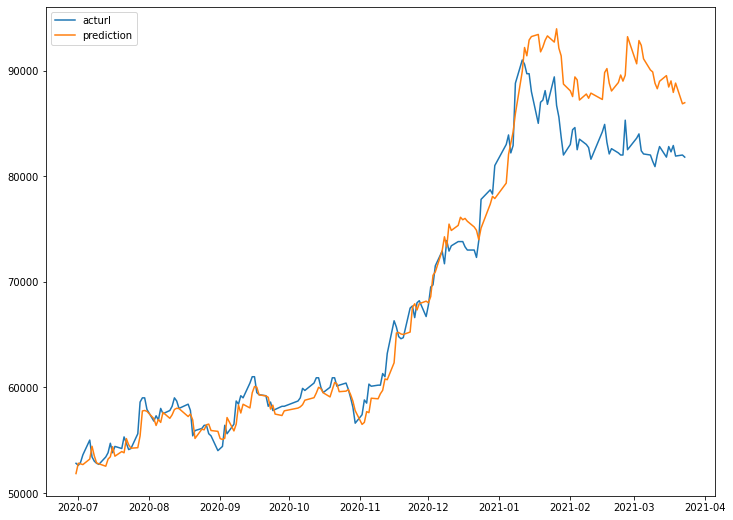

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,9))
plt.plot(df.loc[3089:,['date']], test_price, label = 'acturl')
plt.plot(df.loc[3089:,['date']], test_predict, label = 'prediction')
plt.legend()
plt.show